In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
def read_thermo(filename):

    with h5py.File(filename, 'r') as f:

        eigs = f['sig2']['re'][...] + 1j*f['sig2']['im'][...]
        k_z = f['k_z'][...]

        lam_f = f.attrs['lam_f']
        l_f = f.attrs['l_f']

    return np.transpose(eigs)/lam_f, k_z/l_f

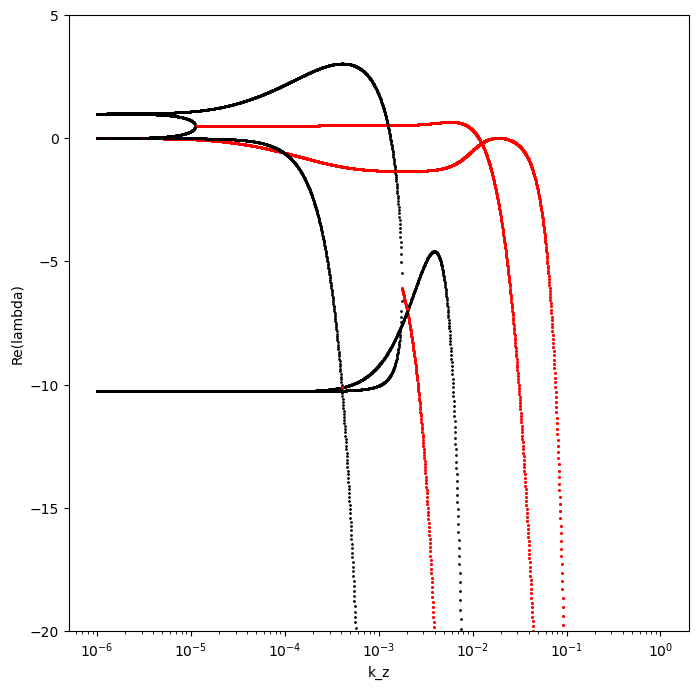

In [3]:
# Read data

eigs, k_z = read_thermo('thermo.h5')

# Plot the results

plt.figure(figsize=[8,8])

d = eigs.shape[0]

for j in range(d):
    i = np.where(np.abs(eigs[j,:].imag) > 1e-12)[0]
    if len(i) > 1:
        plt.scatter(k_z[i], eigs[j,i].real, 1, color='r')
    i = np.where(np.abs(eigs[j,:].imag) < 1e-12)[0]
    if len(i) > 1:
        plt.scatter(k_z[i], eigs[j,i].real, 1, color='k')

plt.xlabel('k_z')
plt.ylabel('Re(lambda)')
plt.ylim(-20, 5)
plt.xscale('log')
